In [1]:
from functools import partial
# import keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, GlobalMaxPool1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization, Activation, concatenate, SpatialDropout1D, TimeDistributed, Layer, AlphaDropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.backend import clear_session
from tensorflow.image import extract_patches
from tensorflow.keras import layers

import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from functools import partial
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score
import sklearn
from sklearn.metrics import confusion_matrix

# Statistics Libraries
import statsmodels.api as sm
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import ttest_rel, mannwhitneyu

# General Libraries
from scipy.io import loadmat, savemat
from scipy.fft import fft, fftfreq, ifft
import h5py
import os

2024-03-13 00:45:27.423472: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Import Performance Results

In [2]:
# Load Model M1 Performance Results
m1_filename = "/data/users3/cellis42/Spectral_Explainability/InterpretableConv/Performance_M1_kt.mat"

m1_testing_metrics = loadmat(m1_filename,appendmat=True)['testing_metrics']

m1_acc = m1_testing_metrics[:,0]
m1_sens = m1_testing_metrics[:,1]
m1_spec = m1_testing_metrics[:,2]
m1_bacc = m1_testing_metrics[:,3]

In [3]:
# Load Model M2 Performance Results
m2_filename = "/data/users3/cellis42/Spectral_Explainability/InterpretableConv/Performance_M2v3_kt.mat"

m2_testing_metrics = loadmat(m2_filename,appendmat=True)['testing_metrics']

m2_acc = m2_testing_metrics[:,0]
m2_sens = m2_testing_metrics[:,1]
m2_spec = m2_testing_metrics[:,2]
m2_bacc = m2_testing_metrics[:,3]

In [4]:
# Load Model M2 Performance Results
m3_filename = "/data/users3/cellis42/Spectral_Explainability/InterpretableConv/Performance_M3_XAIWC_kt.mat"

m3_testing_metrics = loadmat(m3_filename,appendmat=True)['testing_metrics']

m3_acc = m3_testing_metrics[:,0]
m3_sens = m3_testing_metrics[:,1]
m3_spec = m3_testing_metrics[:,2]
m3_bacc = m3_testing_metrics[:,3]

In [5]:
# Concatenaste Performance Results

acc_vals = np.array([m1_acc, m2_acc, m3_acc])

bacc_vals = np.array([m1_bacc, m2_bacc, m3_bacc])

sens_vals = np.array([m1_sens, m2_sens, m3_sens])

spec_vals = np.array([m1_spec, m2_spec, m3_spec])

n_tests = 3
p_vals_bacc = np.ones((n_tests,n_tests)); t_stat_bacc = np.zeros((n_tests,n_tests));
p_vals_acc = np.ones((n_tests,n_tests)); t_stat_acc = np.zeros((n_tests,n_tests));
p_vals_sens = np.ones((n_tests,n_tests)); t_stat_sens = np.zeros((n_tests,n_tests));
p_vals_spec = np.ones((n_tests,n_tests)); t_stat_spec = np.zeros((n_tests,n_tests));

for i in range(n_tests):
    for j in range(n_tests):
        if i > j:
            t_stat_acc[i,j], p_vals_acc[i,j] = ttest_rel(acc_vals[i,:],acc_vals[j,:])
            t_stat_bacc[i,j], p_vals_bacc[i,j] = ttest_rel(bacc_vals[i,:],bacc_vals[j,:])
            t_stat_sens[i,j], p_vals_sens[i,j] = ttest_rel(sens_vals[i,:],sens_vals[j,:])
            t_stat_spec[i,j], p_vals_spec[i,j] = ttest_rel(spec_vals[i,:],spec_vals[j,:])

In [8]:
p_vals_acc_reshaped = []; p_vals_sens_reshaped = []; p_vals_spec_reshaped = []; p_vals_bacc_reshaped = [];

for row in range(1,np.shape(p_vals_bacc)[1]):
    for col in range(0,row):
        p_vals_acc_reshaped.append(p_vals_acc[row,col])
        p_vals_bacc_reshaped.append(p_vals_bacc[row,col])
        p_vals_sens_reshaped.append(p_vals_sens[row,col])
        p_vals_spec_reshaped.append(p_vals_spec[row,col])

In [9]:
p_vals_acc_reshaped_corrected = fdrcorrection(p_vals_acc_reshaped)[1]; p_vals_acc_corrected = np.ones_like(p_vals_acc)
p_vals_bacc_reshaped_corrected = fdrcorrection(p_vals_bacc_reshaped)[1]; p_vals_bacc_corrected = np.ones_like(p_vals_bacc)
p_vals_sens_reshaped_corrected = fdrcorrection(p_vals_sens_reshaped)[1]; p_vals_sens_corrected = np.ones_like(p_vals_sens)
p_vals_spec_reshaped_corrected = fdrcorrection(p_vals_spec_reshaped)[1]; p_vals_spec_corrected = np.ones_like(p_vals_spec)

idx = 0
for row in range(1,np.shape(p_vals_acc)[1]):
    for col in range(0,row):
        p_vals_acc_corrected[row,col] = p_vals_acc_reshaped_corrected[idx]
        p_vals_bacc_corrected[row,col] = p_vals_bacc_reshaped_corrected[idx]
        p_vals_sens_corrected[row,col] = p_vals_sens_reshaped_corrected[idx]
        p_vals_spec_corrected[row,col] = p_vals_spec_reshaped_corrected[idx]
        
        idx += 1

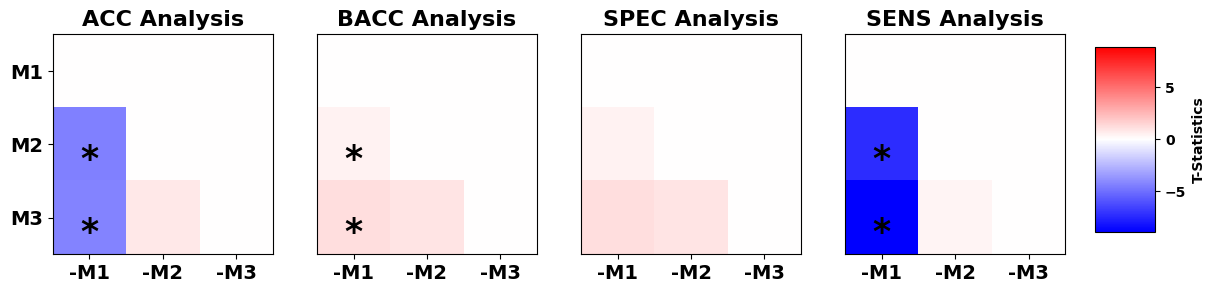

In [11]:
fig, ax = plt.subplots(1,4,figsize=(15,5))
for idx in range(4):
    if idx == 0:
        t_stat = t_stat_acc.copy()
        p_vals_corrected = p_vals_acc_corrected.copy()
        title_val = 'ACC '
    elif idx == 1:
        t_stat = t_stat_spec.copy()
        p_vals_corrected = p_vals_bacc_corrected.copy()
        title_val = 'BACC '
    elif idx == 2:
        t_stat = t_stat_spec.copy()
        p_vals_corrected = p_vals_spec_corrected.copy()
        title_val = 'SPEC '
    elif idx == 3:
        t_stat = t_stat_sens.copy()
        p_vals_corrected = p_vals_sens_corrected.copy()
        title_val = 'SENS '

    max_val = np.max(np.absolute(np.concatenate((t_stat_acc,t_stat_sens,t_stat_spec))))
    
    t_stat2 = t_stat.copy()
    for i in range(n_tests):
        for j in range(n_tests):
            if t_stat[i,j] == 0:
                t_stat2[i,j] = np.nan
    im = ax[idx].imshow(t_stat,cmap='bwr',vmin = -1*max_val,vmax=max_val)
    if idx == 0:
        ax[idx].set_yticks(np.arange(n_tests))
        ax[idx].set_yticklabels(['M1','M2','M3'],weight='bold',fontsize=14)
    else:
        ax[idx].set_yticks([])
    ax[idx].set_xticks(np.arange(n_tests))
    ax[idx].set_xticklabels(['-M1','-M2','-M3'],weight='bold',fontsize=14)
    ax[idx].set_title(title_val + 'Analysis',weight='bold',fontsize=16)
    for i in range(n_tests):
        for j in range(n_tests):
            if p_vals_corrected[i,j] < 0.05:
                ax[idx].text(j,i+0.21,'*',color='k',weight='bold',fontsize=25,verticalalignment='center',horizontalalignment='center')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([.82, 0.32, 0.04, 0.37]) # left bottom width height
cb = fig.colorbar(im, cax=cbar_ax);
cb.set_label(label='T-Statistics',weight='bold')
plt.setp(cb.ax.get_yticklabels(),weight='bold');

plt.savefig('/home/users/cellis42/Spectral_Explainability/InterpretableConv/ResultsFigures/Performance_Testing_XAIWC.png')

## Import Data

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

folderpath = '/data/users3/cellis42/Spectral_Explainability/PreTraining/Data/'
filepath = [folderpath + 'segmented_hc1_data_like_sleep.npy',
            folderpath + 'segmented_hc2_data_like_sleep.npy',
            folderpath + 'segmented_mdd1_data_like_sleep.npy',
            folderpath + 'segmented_mdd2_data_like_sleep.npy']

for i in np.arange(4):

    f = np.load(filepath[i],allow_pickle=True).item()
    
    if i == 0:
        data = f['data']
        labels = f['label']
        groups = f['subject']
    else:
        data = np.concatenate((data,f['data']),axis=0)
        labels = np.concatenate((labels,f['label']),axis=0)
        groups = np.concatenate((groups,f['subject']),axis=0)
        channels = f['channels']
                
channels2 = []
for i in range(19):
    channels2.append(channels[i].strip('EEG ').strip('-L'))

channels = channels2
channels2 = []

data = np.swapaxes(data,1,2)
# data = np.expand_dims(data,axis=3)

2024-03-13 00:46:52.559857: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-03-13 00:46:52.563044: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-03-13 00:46:52.611820: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:c1:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2024-03-13 00:46:52.611871: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-03-13 00:46:52.716173: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-03-13 00:46:52.716296: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.

Num GPUs Available:  1


## Define Optimal Architectures

In [13]:
## Define Base Model
    
def get_Model_M1():
    dropout1= 0.3
    dropout2= 0.5

    n_timesteps = 3000
    n_features = 19

    convLayer = partial(Conv1D,activation='elu',kernel_initializer='he_normal',padding='valid',
                        kernel_constraint=max_norm(max_value = 1))

    model = Sequential()

    kernel_size = 15

    model.add(convLayer(filters = 20, 
                        kernel_size= kernel_size, 
                        strides=1, 
                        input_shape=(n_timesteps, n_features), 
                        data_format='channels_last'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(BatchNormalization())
    
    n_filters = [15,10,15]
    for block in range(1,4): 
        model.add(convLayer(filters = n_filters[block-1], 
                            kernel_size= kernel_size, 
                            strides=1))
        model.add(MaxPooling1D(pool_size=2, strides=2))
        model.add(BatchNormalization())

    model.add(Flatten())
    model.add(AlphaDropout(rate= dropout1))

    n_nodes = [16, 32]
    for dense_block in range(2):
        model.add(Dense(units = n_nodes[dense_block], activation='elu', kernel_initializer='he_normal', kernel_constraint=max_norm(max_value = 1),name = f"dense_l{dense_block}"))
        model.add(AlphaDropout(rate= dropout2))

    model.add(Dense(2, activation='softmax', kernel_initializer='glorot_normal', kernel_constraint=max_norm(max_value = 1),name="dense_output"))

    learning_rate = 5e-5
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy',
                     metrics = ['acc'])

    return model

In [14]:
model = get_Model_M1()
model.summary()

2024-03-13 00:47:20.660154: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-13 00:47:20.660434: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-03-13 00:47:20.661460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:c1:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2024-03-13 00:47:20.661507: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-03-13 00:47:20.661561: I tensorflow/stream_executor/platform

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2986, 20)          5720      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1493, 20)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1493, 20)          80        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1479, 15)          4515      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 739, 15)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 739, 15)           60        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 725, 10)           2

In [15]:
def get_Model_M2():

    n_timesteps = 3000
    n_features = 19

    convLayer2D = partial(Conv2D,activation='elu',kernel_initializer='he_normal',padding='valid',
                    kernel_constraint=max_norm(max_value = 1))

    convLayer1D = partial(Conv1D,activation='elu',kernel_initializer='he_normal',padding='valid',
                        kernel_constraint=max_norm(max_value = 1))

    inputs = Input(shape=(n_timesteps, n_features))

    x = tf.transpose(inputs,perm=[0,2,1])

    stride_kernel_size_0 = 50
    x = tf.keras.layers.Reshape((int(n_timesteps*n_features),1))(x)
    x = convLayer1D(filters = 20,
                    kernel_size = stride_kernel_size_0, 
                    strides = stride_kernel_size_0,
                    data_format='channels_last')(x)

    x = tf.expand_dims(x,axis=3)
    x_shape = x.shape
    x = tf.split(x,19,1)
    x = tf.keras.layers.Concatenate(axis=3)(x)
    x = tf.transpose(x,perm=[0,1,3,2])
    x = BatchNormalization()(x)

    stride_size_1 = 10
    kernel_size_1 = 10
    x = convLayer2D(filters=1,
                    kernel_size= (kernel_size_1,1), 
                    strides=(stride_size_1,1),
                    data_format='channels_last')(x)
    x = tf.squeeze(x,axis=3)
    x = tf.keras.layers.GlobalAveragePooling1D(data_format='channels_last')(x)
    x = BatchNormalization()(x)
    x = Dense(12,activation='relu')(x)
    x = Dropout(rate=0.3)(x)
    outputs = Dense(2,activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    learning_rate = 0.001
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy',
                     metrics = ['acc'])

    return model

In [16]:
model = get_Model_M2()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3000, 19)]   0                                            
__________________________________________________________________________________________________
tf.compat.v1.transpose (TFOpLam (None, 19, 3000)     0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 57000, 1)     0           tf.compat.v1.transpose[0][0]     
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 1140, 20)     1020        reshape[0][0]                    
______________________________________________________________________________________________

In [17]:
def get_Model_M3():

    n_timesteps = 3000
    n_features = 19

    convLayer2D = partial(Conv2D,activation='elu',kernel_initializer='he_normal',padding='valid',
                    kernel_constraint=max_norm(max_value = 1))

    convLayer1D = partial(Conv1D,activation='elu',kernel_initializer='he_normal',padding='valid',
                        kernel_constraint=max_norm(max_value = 1))

    inputs = Input(shape=(n_timesteps, n_features))

    x = tf.transpose(inputs,perm=[0,2,1])

    stride_kernel_size_0 = 50
    x = tf.keras.layers.Reshape((int(n_timesteps*n_features),1))(x)
    x = convLayer1D(filters = 20,
                    kernel_size = stride_kernel_size_0, 
                    strides = stride_kernel_size_0,
                    data_format='channels_last')(x)

    x = tf.expand_dims(x,axis=3)
    x_shape = x.shape
    x = tf.split(x,19,1)
    x = tf.keras.layers.Concatenate(axis=3)(x)
    x = tf.transpose(x,perm=[0,1,3,2])
    x = BatchNormalization()(x)

    stride_size_1 = 10
    kernel_size_1 = 5
    x = convLayer2D(filters=1,
                    kernel_size= (kernel_size_1,1), 
                    strides=(stride_size_1,1),
                    data_format='channels_last')(x)
    x = tf.squeeze(x,axis=3)
    x = tf.keras.layers.GlobalAveragePooling1D(data_format='channels_last')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.1)(x)
    outputs = Dense(2,activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    learning_rate = 0.001
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy',
                     metrics = ['acc'])

    return model

In [18]:
model = get_Model_M3()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 3000, 19)]   0                                            
__________________________________________________________________________________________________
tf.compat.v1.transpose_2 (TFOpL (None, 19, 3000)     0           input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 57000, 1)     0           tf.compat.v1.transpose_2[0][0]   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 1140, 20)     1020        reshape_1[0][0]                  
____________________________________________________________________________________________

## Define Explainability Functions

In [19]:
# Spectral Explainability Function
def Perturbation_Freq(model,X,Y):
    
    N = np.shape(X)[0]
    Fs = 100 # Sampling Rate
    timestep = 1/Fs # Step Size
    
    # Define Frequency Bins
    bins = [];
    bins.append([0,4]) # delta
    bins.append([4,8]) # theta
    bins.append([8,12]) # alpha
    bins.append([12,25]) # beta
    bins.append([25,45]) # gamma

    bins = np.array(bins)
    
    n_bins = np.shape(bins)[0]
    
    initial_pred = np.argmax(model.predict(X),axis=1)
    
    acc_1 = accuracy_score(Y,initial_pred)
    
    freq = np.fft.fftfreq(np.shape(X)[1], d=timestep) # 5000 sample frequencies
    
    # Identify Frequency Values Associated with Each Frequency Bin
    bins2 = np.zeros_like(freq) # preallocate array to store marker that identifies bin
    
    for bin_val in range(np.shape(bins)[0]): # for each frequency band
        positive = np.logical_and(freq>bins[bin_val,0]*np.ones_like(freq),freq<bins[bin_val,1]*np.ones_like(freq)) # indices between positive frequencies
        negative = np.logical_and(freq<-1*bins[bin_val,0]*np.ones_like(freq),freq>-1*bins[bin_val,1]*np.ones_like(freq)) # indices between negative frequencies
        vals = positive + negative # all samples within bin (OR the arrays)
        bins2[vals] = bin_val*np.ones((np.sum(vals),)) # assign marker to frequency values in each bin
    
    # Perturbation Explainability
    
    acc_change = np.zeros((n_bins,))
    
    #perform fft for all channels
    fft_vals = np.fft.fft(X_test,axis=1)
    
    for bin_val in range(n_bins): # iterate over each frequency band
        
        # Duplicate Samples
        fft_vals2 = fft_vals.copy()
        
        # Zero-out Frequency Values
        fft_sub = np.zeros_like(fft_vals2[:,np.squeeze(list(bins2 == bin_val*np.ones_like(bins2))),:])
        fft_vals2[:,np.squeeze(list(bins2 == bin_val*np.ones_like(bins2)))] = fft_sub

        # Convert Perturbed Samples Back to Time Domain
        feature_ifft = np.fft.ifft(fft_vals2,axis=1);
        X_2 = feature_ifft

        after_pred = np.argmax(model.predict(X_2),axis=1)
        acc_2 = accuracy_score(Y,after_pred)

        acc_change[bin_val] = 100*(acc_2 - acc_1)/acc_1

        print('Freq ' + str(bin_val))
                        
    return (acc_change)

In [20]:
# Spatial Perturbation Function

def Perturbation_Channel(model,X,Y):
    
    N = np.shape(X)[0] 
    N_Timepoints = np.shape(X)[1]
    N_Channels = np.shape(X)[2]
    
    initial_pred = np.argmax(model.predict(X),axis=1)
    
    acc_1 = accuracy_score(Y,initial_pred)
    
    # Perturbation Explainability
    
    acc_change = np.zeros((19,1))
    
    for channel in np.arange(N_Channels):
            X_2 = X.copy()
            
            # Replace channel with zeros
            X_2[:,:,channel] = np.zeros((N,N_Timepoints))

            after_pred = np.argmax(model.predict(X_2),axis=1)
            acc_2 = accuracy_score(Y,after_pred)

            acc_change[channel] = 100*(acc_2 - acc_1)/acc_1
            
            print('Channel ' + str(channel))
                        
    return (acc_change)

## Perform Explainability Analysis

In [21]:
gss = GroupShuffleSplit(n_splits = 50, train_size = 0.9, random_state = 3) # 2

spectral_importance_M1 = []; spectral_importance_M2 = []; spectral_importance_M3 = [];
spatial_importance_M1 = []; spatial_importance_M2 = []; spatial_importance_M3 = [];

i = 0
for tv_idx, test_idx in gss.split(data, labels, groups):

    print('Fold = ' +str(i))

    X_test = data[test_idx,...]
    Y_test = labels[test_idx,...]
                
    # Model M1
    clear_session()
    M1_path = "/data/users3/cellis42/Spectral_Explainability/InterpretableConv/model_M1_kt_fold0"+str(i)+".hdf5"

    model = get_Model_M1()
    model.load_weights(M1_path)
    
    spectral_importance_M1.append(Perturbation_Freq(model,X_test,Y_test))
    spatial_importance_M1.append(Perturbation_Channel(model,X_test,Y_test))
    
    # Model M2
    clear_session()
    M2_path = "/data/users3/cellis42/Spectral_Explainability/InterpretableConv/model_M2v3_kt_fold0"+str(i)+".hdf5"

    model = get_Model_M2()
    model.load_weights(M2_path)
    
    spectral_importance_M2.append(Perturbation_Freq(model,X_test,Y_test))
    spatial_importance_M2.append(Perturbation_Channel(model,X_test,Y_test))
    
    # Model M3
    clear_session()
    M3_path = "/data/users3/cellis42/Spectral_Explainability/InterpretableConv/model_M3_XAIWC_kt_fold0"+str(i)+".hdf5"

    model = get_Model_M3()
    model.load_weights(M3_path)
    
    spectral_importance_M3.append(Perturbation_Freq(model,X_test,Y_test))
    spatial_importance_M3.append(Perturbation_Channel(model,X_test,Y_test))

    i += 1

Fold = 0


2024-03-13 00:52:36.875349: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-03-13 00:52:36.903460: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1996275000 Hz
2024-03-13 00:52:37.295593: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-03-13 00:52:37.817875: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-03-13 00:52:40.201903: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2024-03-13 00:52:40.262565: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Freq 0
Freq 1
Freq 2
Freq 3
Freq 4
Channel 0
Channel 1
Channel 2
Channel 3
Channel 4
Channel 5
Channel 6
Channel 7
Channel 8
Channel 9
Channel 10
Channel 11
Channel 12
Channel 13
Channel 14
Channel 15
Channel 16
Channel 17
Channel 18
Freq 0
Freq 1
Freq 2
Freq 3
Freq 4
Channel 0
Channel 1
Channel 2
Channel 3
Channel 4
Channel 5
Channel 6
Channel 7
Channel 8
Channel 9
Channel 10
Channel 11
Channel 12
Channel 13
Channel 14
Channel 15
Channel 16
Channel 17
Channel 18
Freq 0
Freq 1
Freq 2
Freq 3
Freq 4
Channel 0
Channel 1
Channel 2
Channel 3
Channel 4
Channel 5
Channel 6
Channel 7
Channel 8
Channel 9
Channel 10
Channel 11
Channel 12
Channel 13
Channel 14
Channel 15
Channel 16
Channel 17
Channel 18
Fold = 1
Freq 0
Freq 1
Freq 2
Freq 3
Freq 4
Channel 0
Channel 1
Channel 2
Channel 3
Channel 4
Channel 5
Channel 6
Channel 7
Channel 8
Channel 9
Channel 10
Channel 11
Channel 12
Channel 13
Channel 14
Channel 15
Channel 16
Channel 17
Channel 18
Freq 0
Freq 1
Freq 2
Freq 3
Freq 4
Channel 0
Channel 1


In [22]:
## Save Explainabilty Results
save_path = "/data/users3/cellis42/Spectral_Explainability/InterpretableConv/XAIWC2024/Comparison_Spectral_Spatial.mat"
savemat(save_path,{'spectral_importance_M1':spectral_importance_M1,'spatial_importance_M1':spatial_importance_M1,
                   'spectral_importance_M2':spectral_importance_M2,'spatial_importance_M2':spatial_importance_M2,
                   'spectral_importance_M3':spectral_importance_M3,'spatial_importance_M3':spatial_importance_M3})

## Visualize Explainability Results

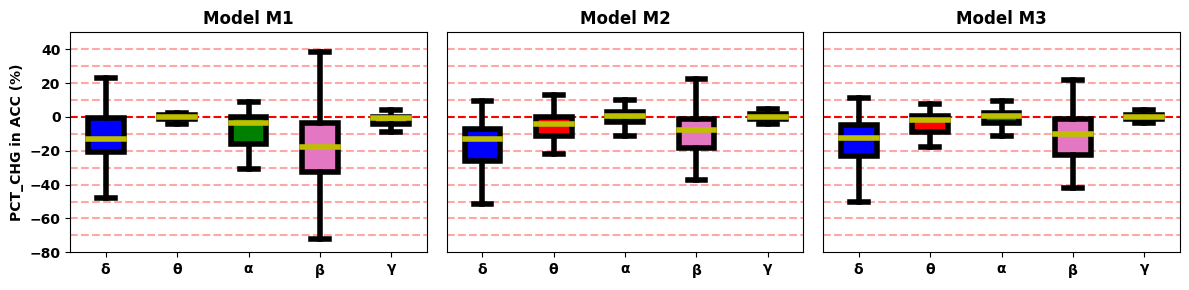

In [23]:
freq_bands = [r'$\mathbf{\delta}$',r'$\mathbf{\theta}$',r'$\mathbf{\alpha}$',r'$\mathbf{\beta}$',r'$\mathbf{\gamma}$']
plt.figure(figsize=(12,3))
for i in range(1,4):
    if i == 1:
        imp = np.squeeze(spectral_importance_M1)
        title = 'Model M1'
    elif i == 2:
        imp = np.squeeze(spectral_importance_M2)
        title = 'Model M2'
    elif i == 3:
        imp = np.squeeze(spectral_importance_M3)
        title = 'Model M3'
        
    plt.subplot(1,3,i)
    
    for hline in range(-7,5):
        if hline != 0:
            plt.hlines([10*hline],0.5,5.5,'r','--',alpha=0.35)
        else:
            plt.hlines([10*hline],0.5,5.5,'r','--',alpha=1)

    bplot = plt.boxplot(imp,patch_artist=True,showfliers=False);
    plt.xticks(np.arange(1,6),freq_bands)
    plt.yticks(weight='bold')
    plt.title(title,weight='bold')
    plt.ylim([-80,50])
    
    if i == 1 or i == 5:
        plt.ylabel('PCT_CHG in ACC (%)',weight='bold')
    else:
        plt.yticks([])
        
    # Set Whisker Color
    for whisker in bplot['whiskers']:
        whisker.set(color='k',linewidth=4)
    
    # Set Caps Color
    for cap in bplot['caps']:
        cap.set(color='k',linewidth=4)
    
    # Set Box Outline Color
    for box in bplot['boxes']:
        box.set(color='k',linewidth=4)
        
    # Set Median Color
    for med in bplot['medians']:
        med.set(color='y',linewidth=4)
    
    # Set Face color
    colors = ['b','r','g','tab:pink','y']
    for count in range(5):
        patch = bplot['boxes'][count]
        color = colors[count]
        patch.set_facecolor(color)
plt.tight_layout()

plt.savefig('/home/users/cellis42/Spectral_Explainability/InterpretableConv/XAIWC2024/ResultsFigures/Spectral_Importance.png')

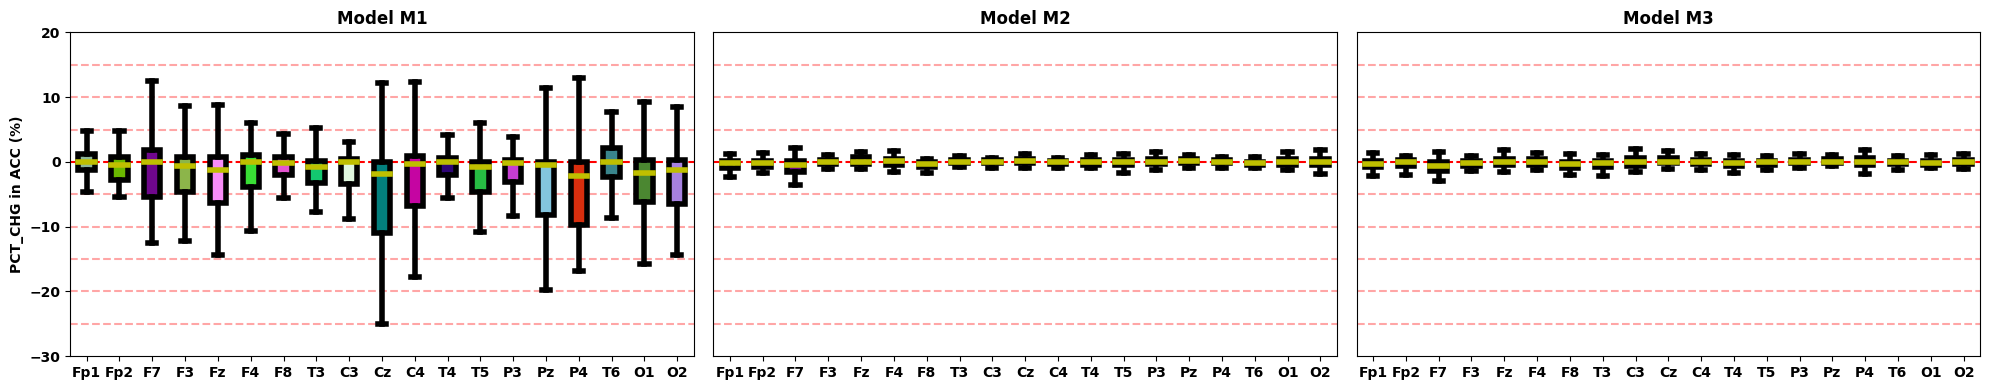

In [24]:
channels = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']

plt.figure(figsize=(20,4))
for i in range(1,4):      
    if i == 1:
        imp = np.squeeze(spatial_importance_M1)
        title = 'Model M1'
    elif i == 2:
        imp = np.squeeze(spatial_importance_M2)
        title = 'Model M2'
    elif i == 3:
        imp = np.squeeze(spatial_importance_M3)
        title = 'Model M3'
        
    order = np.arange(19)#np.argsort(np.quantile(imp,0.25,axis=0))
    
    plt.subplot(1,3,i)
    for hline in range(-5,4):
        if hline != 0:
            plt.hlines([5*hline],0.5,19.5,'r','--',alpha=0.35)
        else:
            plt.hlines([5*hline],0.5,19.5,'r','--',alpha=1)    
    bplot = plt.boxplot(imp[:,order],patch_artist=True,showfliers=False);
    plt.yticks([-30,-20,-10,0,10,20],weight='bold')
    plt.xticks(np.arange(1,20),np.array(channels)[order],weight='bold')
    plt.title(title,weight='bold')
    plt.ylim([-30,20])
    
    if i == 1:
        plt.ylabel('PCT_CHG in ACC (%)',weight='bold')
    else:
        plt.yticks([])
    
    # Set Whisker Color
    for whisker in bplot['whiskers']:
        whisker.set(color='k',linewidth=4)
    
    # Set Caps Color
    for cap in bplot['caps']:
        cap.set(color='k',linewidth=4)
    
    # Set Box Outline Color
    for box in bplot['boxes']:
        box.set(color='k',linewidth=4)
        
    # Set Median Color
    for med in bplot['medians']:
        med.set(color='y',linewidth=4)
    
    # Set Face Color
    for count in range(19):
        patch = bplot['boxes'][count]
        np.random.seed(order[count])
        patch.set_facecolor(np.random.rand(3,))
    
plt.tight_layout()

    
plt.savefig('/home/users/cellis42/Spectral_Explainability/InterpretableConv/XAIWC2024/ResultsFigures/Spatial_Importance.png')